<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Notebooks-settings-and-libraries" data-toc-modified-id="Notebooks-settings-and-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Notebooks settings and libraries</a></span><ul class="toc-item"><li><span><a href="#Notebook-magic" data-toc-modified-id="Notebook-magic-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Notebook magic</a></span></li><li><span><a href="#Import-libraries" data-toc-modified-id="Import-libraries-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Import libraries</a></span></li><li><span><a href="#Plotting-style" data-toc-modified-id="Plotting-style-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Plotting style</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Functions</a></span></li></ul></li><li><span><a href="#Generate-data" data-toc-modified-id="Generate-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Generate data</a></span></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Analysis</a></span><ul class="toc-item"><li><span><a href="#Frequentist-approach" data-toc-modified-id="Frequentist-approach-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Frequentist approach</a></span><ul class="toc-item"><li><span><a href="#T-test" data-toc-modified-id="T-test-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span><a href="https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.ttest_ind.html" target="_blank">T-test</a></a></span></li><li><span><a href="#Permutation-test" data-toc-modified-id="Permutation-test-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Permutation test</a></span></li></ul></li><li><span><a href="#Bayesian-approach" data-toc-modified-id="Bayesian-approach-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Bayesian approach</a></span></li></ul></li></ul></div>

# Notebooks settings and libraries

## Notebook magic

In [1]:
%matplotlib inline

## Import libraries

In [2]:
import pandas as pd
import itertools
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import random
import numpy as np
import matplotlib.colors
from matplotlib.colors import ListedColormap
from statsmodels.formula.api import ols
import pymc3 as pm
from scipy import optimize
import scipy.stats

## Plotting style

In [3]:
plt.style.use('seaborn-white')
sns.set_style('white')
palette = sns.color_palette()

## Functions

In [4]:
def plot_norm(mu, var, **kwargs):
    x = np.linspace(scipy.stats.norm.ppf(0.001, loc = mu, scale = var**0.5),
                    scipy.stats.norm.ppf(0.999, loc = mu, scale = var**0.5), 100)
    plt.plot(x, scipy.stats.norm.pdf(x, loc = mu, scale = var**0.5),
         lw=5, alpha=0.6, **kwargs)

In [5]:
def run_permutation_test(X, Y):
    pooled = np.concatenate((X, Y))
    random.seed()
    np.random.shuffle(pooled)
    X_new = pooled[:len(X)]
    Y_new = pooled[-len(Y):]
    return X_new.mean() - Y_new.mean()

# Generate data

Parameters of the population distributions

In [6]:
mu_t = 5.5
var_t = 2
mu_c = 5.
var_c = 2
N = 1000

Generate samples of the populations

In [7]:
treatment = np.random.normal(mu_t, var_t**0.5, N)
control = np.random.normal(mu_c, var_c**0.5, N)

Population vs sample distributions

Text(0,0.5,'Probability density')

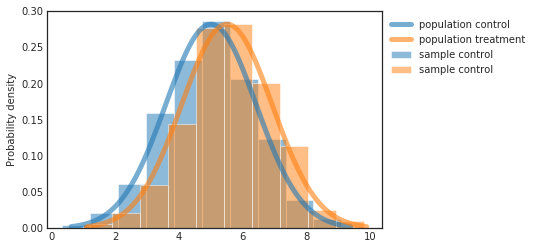

In [8]:
#Population distributions
plot_norm(mu_c, var_c, label = 'population control', color = palette[0])
plot_norm(mu_t, var_t, label = 'population treatment', color = palette[1])

#Sample distributions
plt.hist(control, alpha = 0.5, density = 'normed', 
         label = 'sample control', color = palette[0])
plt.hist(treatment, alpha = 0.5, density = 'normed', 
         label = 'sample control', color = palette[1])
plt.legend(bbox_to_anchor = (1,1))
plt.ylabel('Probability density')

# Analysis

## Frequentist approach

### [T-test](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.ttest_ind.html) 

T-test is a two-sided test for the null hypothesis that 2 independent samples have identical average (expected) values. This test assumes that the populations have identical variances.

In [9]:
t0, p_2_sided = scipy.stats.ttest_ind(treatment, control, axis=0, equal_var=True)
print('t0 = {}'.format(round(t0, 2)))
print('p-value (2-sided) = {}'.format(round(p_2_sided, 2)))

t0 = 9.88
p-value (2-sided) = 0.0


Test calculates t-statistics and two-sided p-value - probability of observing t >= $|t_0|$ under the null hypothesis.

Under the null hypothesis t-statistics is distributed according to [Student distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution). It has heavier tails which reflects the underestimation of the variances from the sample distributions, but approaches normal for the larger number of samples.

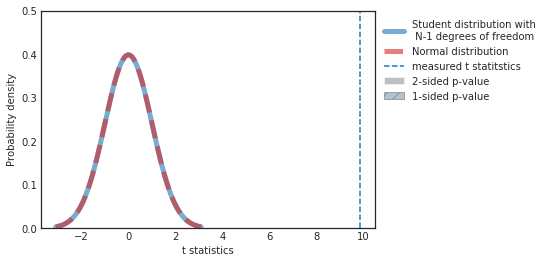

In [10]:
#Plot Student distribution
x = np.linspace(scipy.stats.t.ppf(0.001, N-1),
  scipy.stats.t.ppf(0.999, N-1), 1000)
plt.plot(x, scipy.stats.t.pdf(x, N-1),
 lw=5, alpha=0.6, label='Student distribution with \n N-1 degrees of freedom')
#Plot normal distribution
plot_norm(0, 1, label = 'Normal distribution', color = palette[3], linestyle = '--')

#Show calculated t statistics
plt.axvline(t0, color = palette[0], label = 'measured t statitstics', linestyle = '--')
#Show p-value
plt.fill_between(x = x[(x <= -t0)], 
                 y1 = scipy.stats.t.pdf(x[(x <= -t0)], N-1), 
                 y2 = 0, facecolor = 'grey', alpha = 0.5,
                label = '2-sided p-value')

plt.fill_between(x = x[(x >= t0)], 
                 y1 = scipy.stats.t.pdf(x[(x >= t0)], N-1), 
                 y2 = 0, facecolor = 'grey', alpha = 0.5)

plt.fill_between(x = x[x >= t0], 
                 y1 = scipy.stats.t.pdf(x[x >= t0], N-1), 
                 y2 = 0, facecolor = 'grey', edgecolor = palette[0], alpha = 0.5,
                label = '1-sided p-value', hatch = '//')

plt.ylim(0, 0.5)
plt.ylabel('Probability density')
plt.xlabel('t statistics')
plt.legend(bbox_to_anchor = (1,1))


As you can see Student distribution is symmetric so to get 1-sided p-value - probability of observing t >= $t_0$ (for alternative hypothesis that treatment has higher mean than control) or t <= -$t_0$ (for alternative hypothesis that treatment has lower mean than control) we can simply divide 2-sided p-value by 2.

In [11]:
p_1_sided = p_2_sided/2
print('p-value (1-sided) = {}'.format(round(p_1_sided, 2)))

p-value (1-sided) = 0.0


Let's see what is actually happenning behind the scenes of t-test. First we calculate t statistics, then we find the p-value of that statistics from the cdf of Student t-distribution with N-1 degrees of freedom.

t-statistics is calculated as 
$$\frac{\bar{X} - \bar{Y}}{\sqrt{Var(\bar{X} - \bar{Y})}} = \frac{\bar{X} - \bar{Y}}{s_p\sqrt{1/n_x + 1/n_y}},$$ where $n_x$ and $n_y$ are the number of points in the sample X and Y respectively and $s_p^2$ is pooled variance of samples weighted by the sample sizes:
$$s_p^2 = \frac{(n_y - 1)s_y^2 + (n_x - 1)s_x^2}{n_x + n_y - 2} $$

In [12]:
t_stat=lambda x, y, var_p: (np.mean(x) - np.mean(y))/(var_p**0.5*(1/len(x) + 1/len(y))**0.5)
var_p = lambda x, y: ((len(x) - 1)*np.var(x) + (len(y) - 1)*np.var(y))/(len(x) + len(y) - 2)

In [13]:
t0_manual = t_stat(treatment, control, var_p(treatment, control))
p_2_sided_manual = (1 - scipy.stats.t.cdf(t0_manual, N-1))*2
print('t0 = {}'.format(round(t0_manual, 2)))
print('p-value (2-sided) = {}'.format(round(p_2_sided_manual, 2)))

t0 = 9.88
p-value (2-sided) = 0.0


As you can see these results match pretty closely to the output of t-test (above).

### Permutation test

Instead of using analytical Student distribution we can also do a [permutation test](https://en.wikipedia.org/wiki/Exact_test) to generate distribution of differences between means of two samples under the null hypothesis.

In [14]:
numSamples = 10000
estimates = list(map(lambda x: run_permutation_test(treatment, control),
                         np.arange(0, numSamples, 1)
                        )
                    )

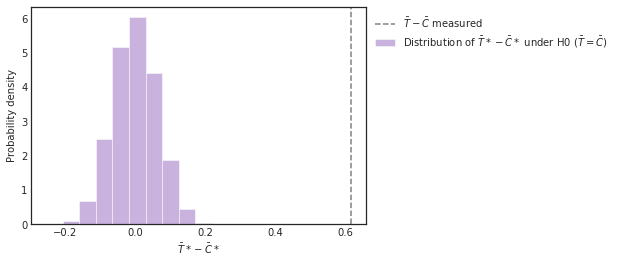

In [15]:
_ = plt.hist(estimates, alpha = 0.5, density = 'normed', 
         label = r'Distribution of $\bar{T}* - \bar{C}*$ under H0 $(\bar{T}  = \bar{C})$', color = palette[4])

plt.ylabel('Probability density')
plt.xlabel(r'$\bar{T}* - \bar{C}*$')
#Show calculated difference
delta = treatment.mean() - control.mean()
plt.axvline(delta, color = 'grey', label = r'$\bar{T} - \bar{C}$ measured', linestyle = '--')
plt.legend(bbox_to_anchor = (1,1))


To find the p-value from this we can just divide the the number of iterations where difference between the two means was higher than the measured difference (dotted line on the figure) by the total number of iterations.

In [16]:
diffCount = len(np.where(estimates >= delta)[0])
p_value_1_sided_perm = (float(diffCount)/float(numSamples))

In [17]:
print('p-value (1-sided from permutation test) = {}'.format(round(p_value_1_sided_perm, 2)))

p-value (1-sided from permutation test) = 0.0


As you can see resulting p-value matches what we got from t-test, which is expected (see [here](https://en.wikipedia.org/wiki/Exact_test))

## Bayesian approach

Generate data

In [18]:
data = pd.DataFrame({'treatment': treatment, 'control': control})

data = data.melt()

Define model and sample

In [19]:
with pm.Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    pm.glm.GLM.from_formula('value ~ variable', data)
    trace = pm.sample(4000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, variable[T.treatment], Intercept]
Sampling 4 chains: 100%|██████████| 18000/18000 [00:33<00:00, 545.14draws/s]
The acceptance probability does not match the target. It is 0.892726118043, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.880821407275, but should be close to 0.8. Try to increase the number of tuning steps.


Examine results

<Figure size 504x504 with 0 Axes>

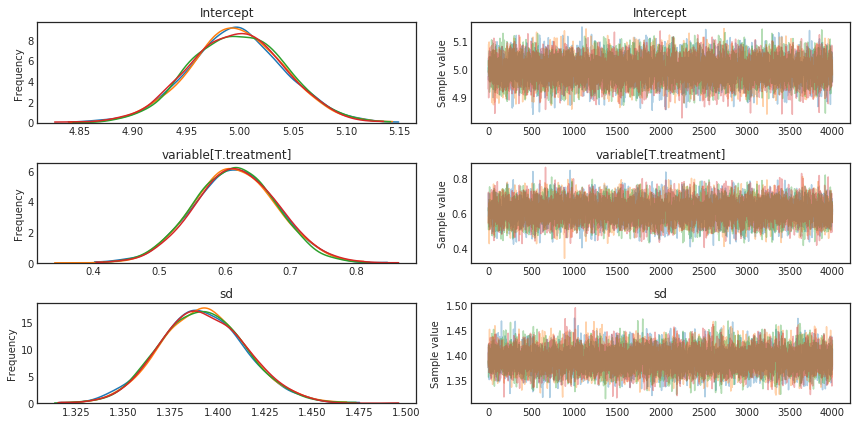

In [20]:
plt.figure(figsize=(7, 7))
pm.traceplot(trace)
plt.tight_layout();

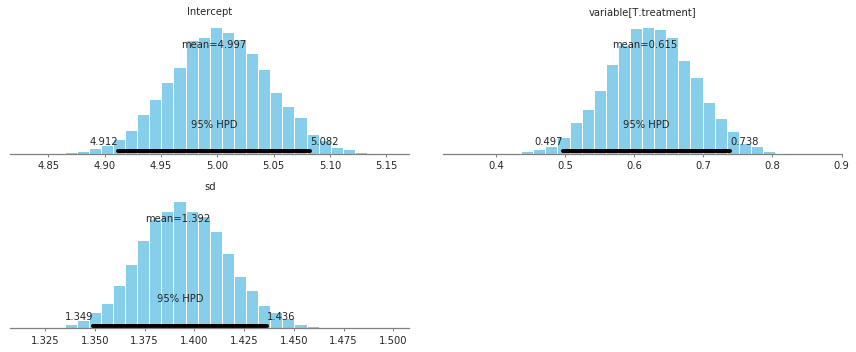

In [21]:
_ = pm.posteriorplot.plot_posterior(trace)

As you can see while we cannot get p-value per se from Bayesian modelling of the data, we can get underlying probability distributions of the population parameters. To compare the different methods note, that 0 is not inside the 95% confidence interval for the effect of treatment compared to control (2nd histogram) and therefore we can reject the null hypothesis (treatment has no effect) at the 95% significance.